### Diabetes Case Study

You now have had the opportunity to work with a range of supervised machine learning techniques for both classification and regression.  Before you apply these in the project, let's do one more example to see how the machine learning process works from beginning to end with another popular dataset.

We will start out by reading in the dataset and our necessary libraries.  You will then gain an understanding of how to optimize a number of models using grid searching as you work through the notebook. 

In [1]:
# Import our libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="ticks")

import check_file as ch

%matplotlib inline

# Read in our dataset
diabetes = pd.read_csv('diabetes.csv')

# Take a look at the first few rows of the dataset
diabetes.head()

C:\Users\olaso\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\olaso\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Because this course has been aimed at understanding machine learning techniques, we have largely ignored items related to parts of the data analysis process that come before building machine learning models - exploratory data analysis, feature engineering, data cleaning, and data wrangling.  

> **Step 1:** Let's do a few steps here.  Take a look at some of usual summary statistics calculated to accurately match the values to the appropriate key in the dictionary below. 

In [2]:
diabetes['Outcome'].value_counts()[1] / len(diabetes['Outcome'])

0.3489583333333333

In [3]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

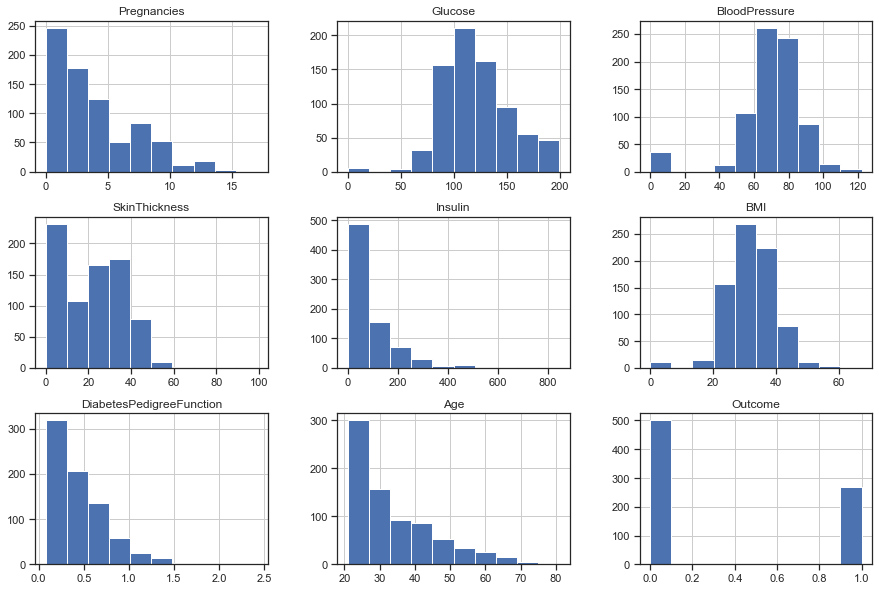

In [4]:
diabetes.hist(figsize=(15,10))
plt.show()

In [5]:
diabetes.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [6]:
# Possible keys for the dictionary
a = '0.65'
b = '0'
c = 'Age'
d = '0.35'
e = 'Glucose'
f = '0.5'
g = "More than zero"

# Fill in the dictionary with the correct values here
# Note: A right-skewed distribution is one in which most values are clustered around the left tail while the right tail  is longer.
answers_one = {
    'The proportion of diabetes outcomes in the dataset': d,
    'The number of missing data points in the dataset': b,
    'A dataset with a symmetric distribution': e,
    'A dataset with a right-skewed distribution': c, 
    'This variable has the strongest correlation with the outcome': e
}

# Just to check your answer, don't change this
ch.check_one(answers_one)

Awesome! These all look great!


> **Step 2**: Since our dataset here is quite clean, we will jump straight into the machine learning.  Our goal here is to be able to predict cases of diabetes.  First, you need to identify the y vector and X matrix.  Then, the following code will divide your dataset into training and test data.   

In [7]:
y = diabetes['Outcome']
X = diabetes.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that you have a training and testing dataset, we need to create some models that and ultimately find the best of them.  However, unlike in earlier lessons, where we used the defaults, we can now tune these models to be the very best models they can be.

It can often be difficult (and extremely time consuming) to test all the possible hyperparameter combinations to find the best models.  Therefore, it is often useful to set up a randomized search.  

In practice, randomized searches across hyperparameters have shown to be more time confusing, while still optimizing quite well.  One article related to this topic is available [here](https://blog.h2o.ai/2016/06/hyperparameter-optimization-in-h2o-grid-search-random-search-and-the-future/).  The documentation for using randomized search in sklearn can be found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) and [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In order to use the randomized search effectively, you will want to have a pretty reasonable understanding of the distributions that best give a sense of your hyperparameters.  Understanding what values are possible for your hyperparameters will allow you to write a grid search that performs well (and doesn't break).

> **Step 3**: In this step, I will show you how to use randomized search, and then you can set up grid searches for the other models in Step 4.  However, you will be helping, as I don't remember exactly what each of the hyperparameters in SVMs do.  Match each hyperparameter to its corresponding tuning functionality.



In [8]:
# build a classifier
clf_rf = RandomForestClassifier()

# Set up the hyperparameter search
param_dist = {"max_depth": [3, None],
              "n_estimators": list(range(10, 200)),
              "max_features": list(range(1, X_test.shape[1]+1)),
              "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


# Run a randomized search over the hyperparameters
random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test data
rf_preds = random_search.best_estimator_.predict(X_test)

ch.print_metrics(y_test, rf_preds, 'random forest')

Accuracy score for random forest : 0.7467532467532467
Precision score random forest : 0.6481481481481481
Recall score random forest : 0.6363636363636364
F1 score random forest : 0.6422018348623852





> **Step 4**: Now that you have seen how to run a randomized grid search using random forest, try this out for the AdaBoost and SVC classifiers.  You might also decide to try out other classifiers that you saw earlier in the lesson to see what works best.

In [28]:
# build a classifier for ada boost
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    "n_estimators": [10,50,60,100,200],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0]
}

abc = AdaBoostClassifier()

rand_search = RandomizedSearchCV(abc, param_distributions=parameters)

rand_search.fit(X_train, y_train)

# Set up the hyperparameter search
# look at  setting up your search for n_estimators, learning_rate
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html


# Run a randomized search over the hyperparameters
# Fit the model on the training data
# Make predictions on the test data
ada_preds = rand_search.best_estimator_.predict(X_test)

# Return your metrics on test data
ch.print_metrics(y_test, ada_preds, 'adaboost')

Accuracy score for adaboost : 0.7662337662337663
Precision score adaboost : 0.6792452830188679
Recall score adaboost : 0.6545454545454545
F1 score adaboost : 0.6666666666666666





In [29]:
# build a classifier for support vector machines
from sklearn.svm import SVC

# Set up the hyperparameter search
# look at setting up your search for C (recommend 0-10 range), 
# kernel, and degree
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svc = SVC()

parameter = [{'C':[1,5,10] , 'kernel':['linear']},
            {'C':[1,5,8,10] ,'kernel':['rbf'] , 'gamma':[0,1,2,0.3,0.2,0.4 ,0.5]}]

# Run a randomized search over the hyperparameters
r_search =RandomizedSearchCV(svc, param_distributions=parameter) 

# Fit the model on the training data
r_search.fit(X_train, y_train)

# Make predictions on the test data
svc_preds = r_search.best_estimator_.predict(X_test)


# Return your metrics on test data
ch.print_metrics(y_test, svc_preds, 'svc')

Accuracy score for svc : 0.7662337662337663
Precision score svc : 0.6792452830188679
Recall score svc : 0.6545454545454545
F1 score svc : 0.6666666666666666





> **Step 5**: Use the test below to see if your best model matched, what we found after running the grid search.  

In [15]:
a = 'randomforest'
b = 'adaboost'
c = 'supportvector'

best_model =  b # put your best model here as a string or variable

# See if your best model was also mine.  
# Notice these might not match depending your search!
ch.check_best(best_model)

Nice!  It looks like your best model matches the best model I found as well!  It makes sense to use f1 score to determine best in this case given the imbalance of classes.  There might be justification for precision or recall being the best metric to use as well - precision showed to be best with adaboost again.  With recall, SVMs proved to be the best for our models.


Once you have found your best model, it is also important to understand why it is performing well.  In regression models where you can see the weights, it can be much easier to interpret results. 

> **Step 6**:  Despite the fact that your models here are more difficult to interpret, there are some ways to get an idea of which features are important.  Using the "best model" from the previous question, find the features that were most important in helping determine if an individual would have diabetes or not. Do your conclusions match what you might have expected during the exploratory phase of this notebook?

> **Step 7**:  Using your results above to complete the dictionary below.

In [26]:
#Pregnancies	Glucose	BloodPressure	SkinThickness	Insulin	
#BMI	DiabetesPedigreeFunction	Age
random_search.best_estimator_.feature_importances_

array([0.06631116, 0.30354844, 0.05955754, 0.05952392, 0.06422117,
       0.18988243, 0.09596568, 0.16098967])

In [27]:
# Check your solution by matching the correct values in the dictionary
# and running this cell
a = 'Age'
b = 'BloodPressure'
c = 'BMI'
d = 'DiabetesPedigreeFunction'
e = 'Insulin'
f = 'Glucose'
g = 'Pregnancy'
h = 'SkinThickness'



sol_seven = {
    'The variable that is most related to the outcome of diabetes' : f ,# letter here,
    'The second most related variable to the outcome of diabetes' : c ,# letter here,
    'The third most related variable to the outcome of diabetes' : a ,# letter here,
    'The fourth most related variable to the outcome of diabetes' : d # letter here
}

ch.check_q_seven(sol_seven)

That's right!  Some of these were expected, but some were a bit unexpected too!


> **Step 8**:  Now provide a summary of what you did through this notebook, and how you might explain the results to a non-technical individual.  When you are done, check out the solution notebook by clicking the orange icon in the upper left.

From dataset analysis we found Glucose,BMI,and Age features have a big effect on diabetes
We applied machine learning algorithms such as Random Forest, AdaBoost, and Support Vector Machines
from their performance metrics we choose adaboost model 